In [15]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [16]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [17]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
WITH Analyzed AS (
SELECT
    date(Datum, '-1 day') AS Datum,
    BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
    BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS Neuinfektionen,
    CASE WHEN TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) > 1000000 THEN NULL ELSE TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) END AS TestungenPCR,
    Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
FROM DataRaw)
SELECT 
    Datum, BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung, HospitalisierungDiff,
    CASE WHEN Neuinfektionen >= 0 THEN Neuinfektionen ELSE NULL END AS Neuinfektionen,
    CASE WHEN TestungenPCR >= 0 THEN TestungenPCR ELSE NULL END AS TestungenPCR,    
    AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
    AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
    AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
FROM Analyzed;
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [18]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [19]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-10,1 600,2 783,11 821,8 498,2 709,7 786,3 148,2 297,8 681,49 323
2022-03-11,1 501,2 372,9 041,8 397,3 327,7 620,3 135,2 491,6 581,44 465
2022-03-12,966,2 589,8 550,6 412,2 122,6 031,2 308,1 797,7 285,38 060
2022-03-13,1 174,1 839,7 394,6 676,1 781,5 194,2 219,1 614,6 329,34 220
2022-03-14,1 384,1 537,7 516,6 529,1 937,5 354,3 618,2 288,6 962,37 125
2022-03-15,1 006,1 723,12 522,10 735,3 776,9 600,3 358,2 811,13 052,58 583
2022-03-16,1 655,3 296,9 792,9 294,3 843,9 310,3 042,2 528,9 285,52 045


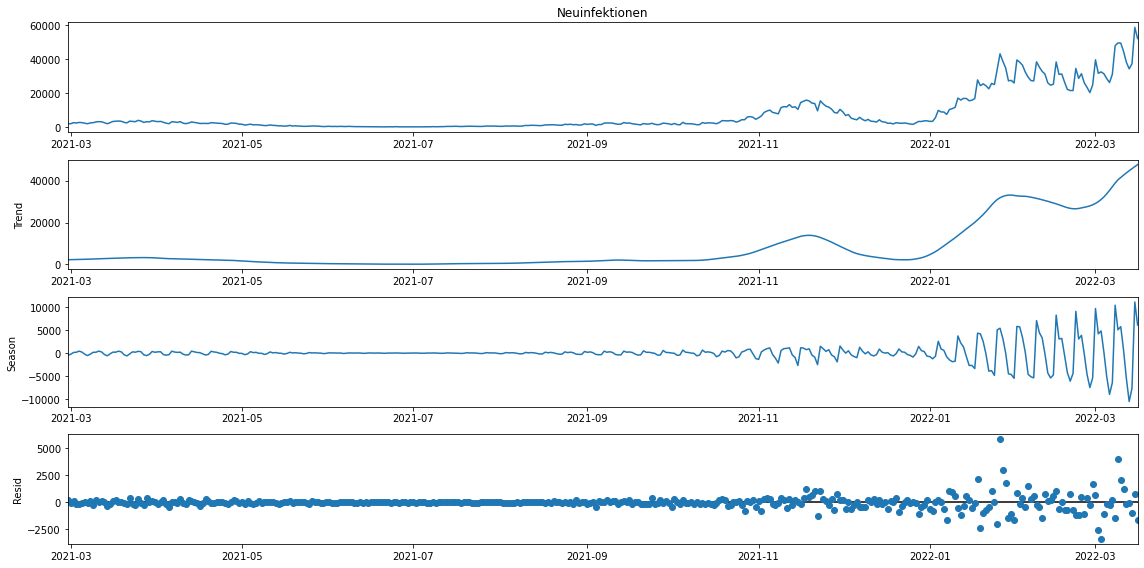

In [20]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [21]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-03-17,54 850
2022-03-18,48 708
2022-03-19,41 091
2022-03-20,36 059
2022-03-21,37 800
2022-03-22,58 116
2022-03-23,52 050


## Hospitalisierung
### Werte der letzten 7 Tage

In [22]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-10,110 (6),226 (5),522 (37),398 (1),99 (-4),447 (16),217 (12),83 (4),649 (6),2 751 (83)
2022-03-11,111 (1),225 (-1),531 (9),403 (5),99 (0),458 (11),210 (-7),83 (0),634 (-15),2 754 (3)
2022-03-12,111 (0),239 (14),509 (-22),437 (34),101 (2),458 (0),210 (0),83 (0),649 (15),2 797 (43)
2022-03-13,111 (0),256 (17),528 (19),436 (-1),102 (1),458 (0),233 (23),100 (17),632 (-17),2 856 (59)
2022-03-14,116 (5),252 (-4),556 (28),469 (33),103 (1),479 (21),233 (0),99 (-1),680 (48),2 987 (131)
2022-03-15,121 (5),278 (26),553 (-3),460 (-9),108 (5),511 (32),217 (-16),105 (6),680 (0),3 033 (46)
2022-03-16,120 (-1),271 (-7),580 (27),489 (29),112 (4),497 (-14),224 (7),95 (-10),698 (18),3 086 (53)


### Diagramm

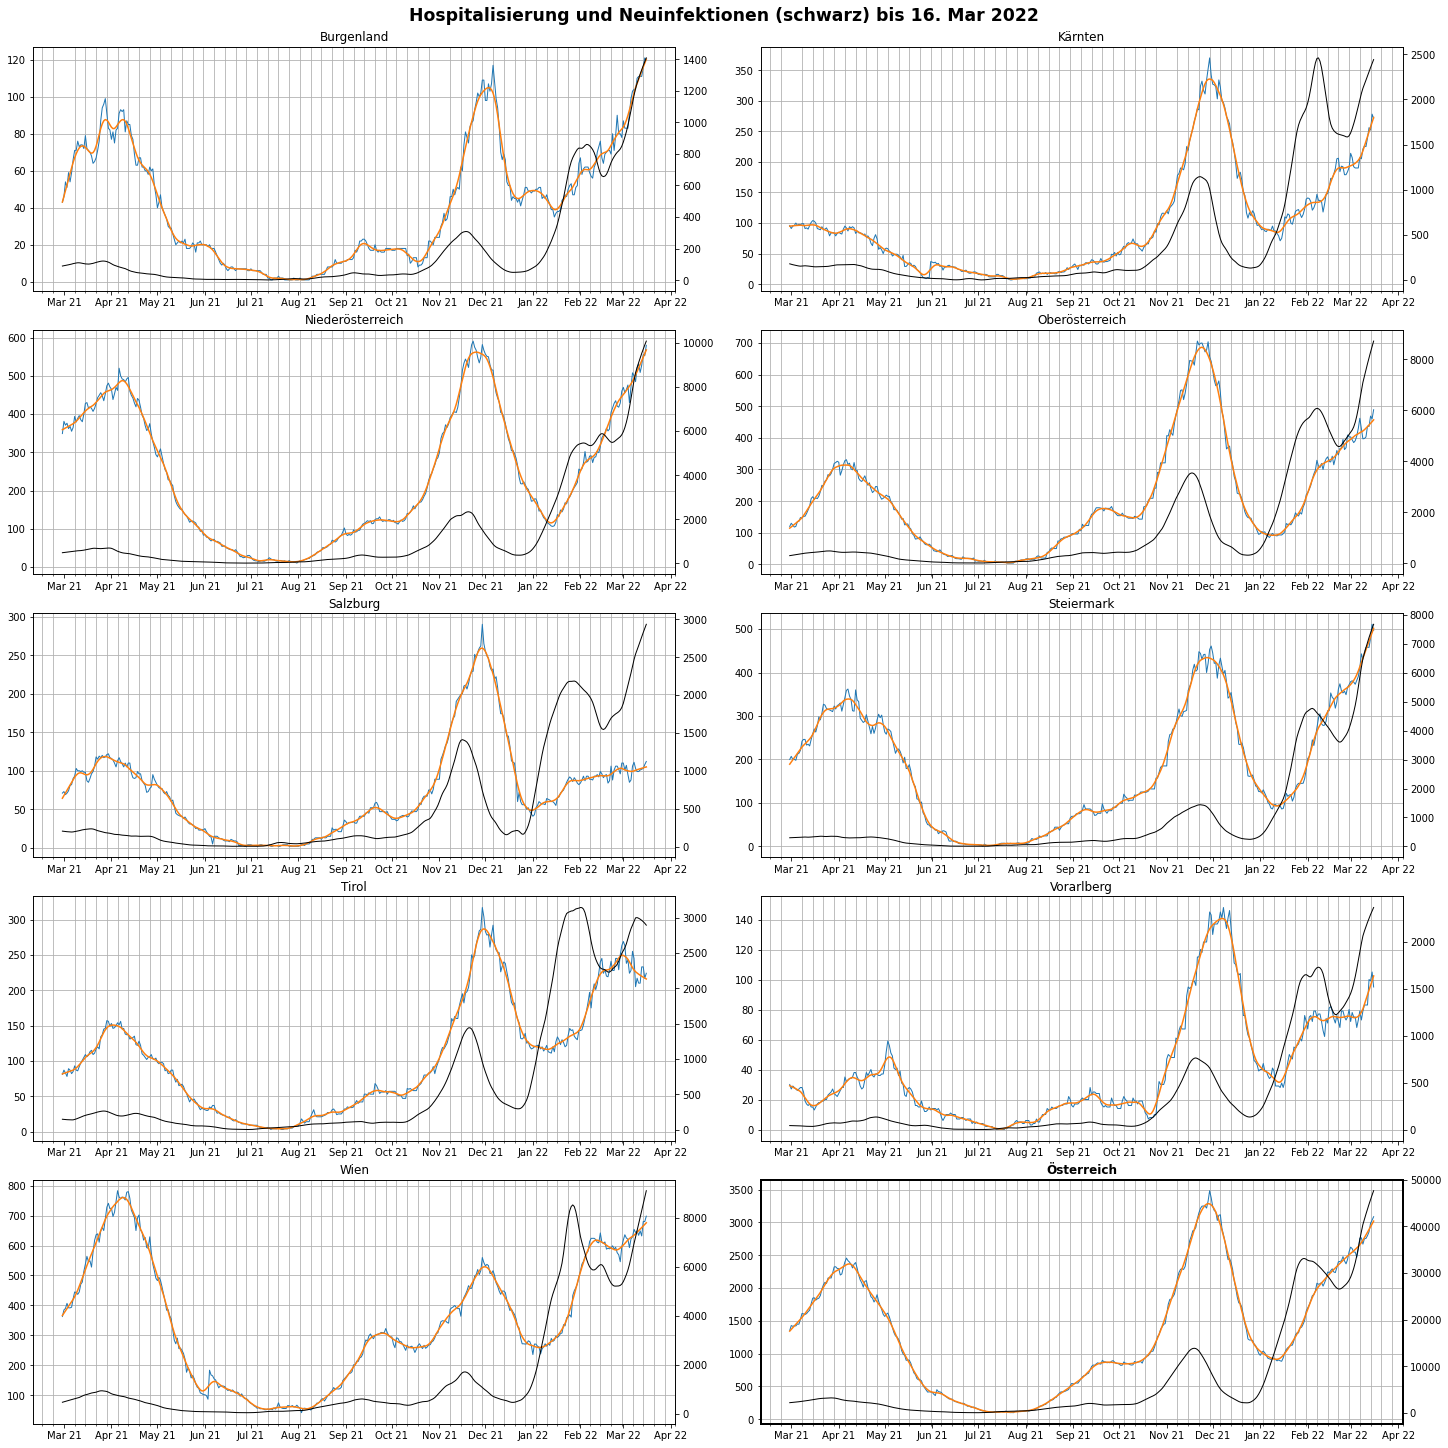

In [23]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

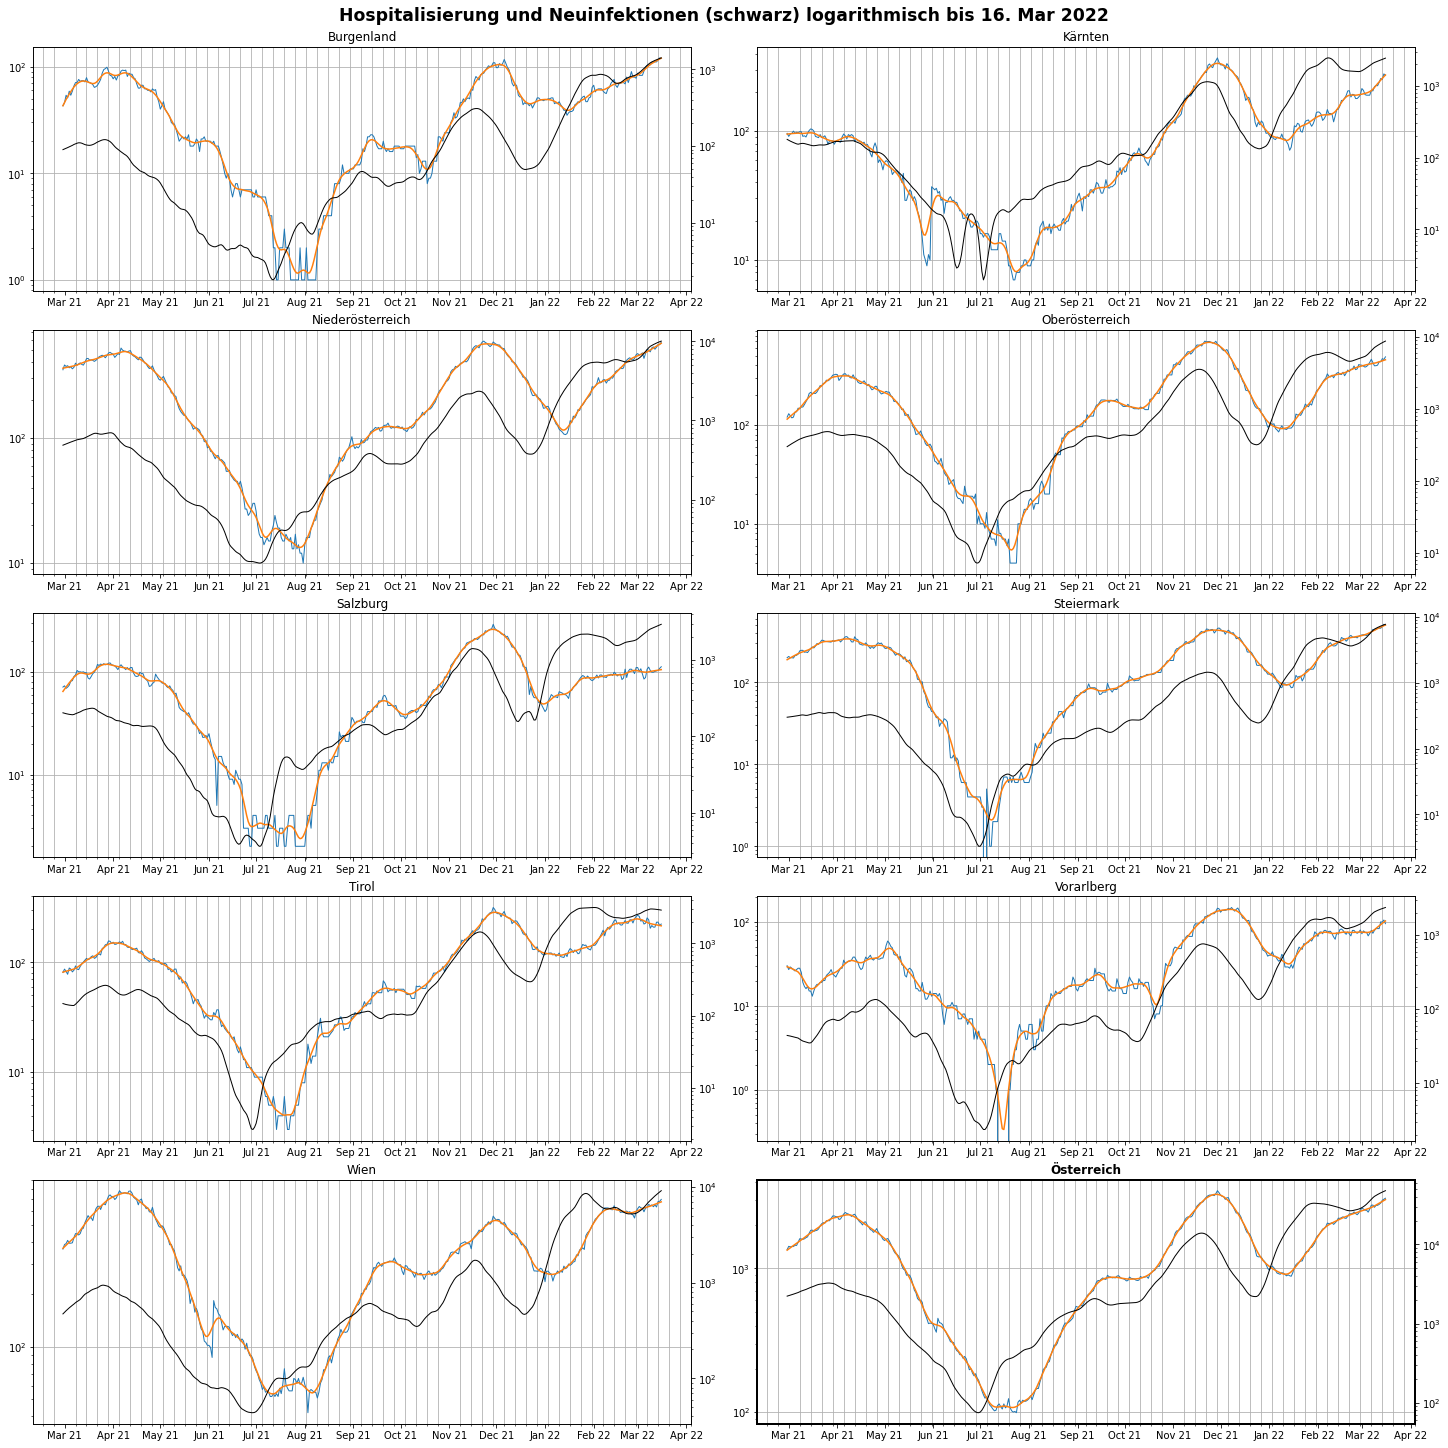

In [24]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [25]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-03-10,8 794 (-2 397),4 757 (-1 052),24 345 (-12 942),25 824 (4 773),13 104 (2 257),25 819 (1 396),15 394 (-2 362),9 027 (3 047),308 019 (-18 933),435 083 (-26 213)
2022-03-11,11 457 (2 663),5 640 (883),267 450 (243 105),27 471 (1 647),10 111 (-2 993),22 938 (-2 881),16 730 (1 336),7 586 (-1 441),246 129 (-61 890),615 512 (180 429)
2022-03-12,7 901 (-3 556),3 183 (-2 457),34 951 (-232 499),21 546 (-5 925),10 279 (168),19 109 (-3 829),14 940 (-1 790),6 616 (-970),225 514 (-20 615),344 039 (-271 473)
2022-03-13,8 099 (198),3 000 (-183),26 958 (-7 993),24 562 (3 016),7 366 (-2 913),20 983 (1 874),10 983 (-3 957),7 276 (660),207 523 (-17 991),316 750 (-27 289)
2022-03-14,9 550 (1 451),3 405 (405),31 714 (4 756),23 445 (-1 117),7 941 (575),19 479 (-1 504),19 805 (8 822),8 400 (1 124),307 791 (100 268),431 530 (114 780)
2022-03-15,5 581 (-3 969),5 752 (2 347),286 409 (254 695),23 939 (494),14 700 (6 759),21 300 (1 821),16 970 (-2 835),10 228 (1 828),337 522 (29 731),722 401 (290 871)
2022-03-16,10 620 (5 039),5 168 (-584),37 436 (-248 973),19 788 (-4 151),12 217 (-2 483),36 855 (15 555),16 468 (-502),8 933 (-1 295),319 214 (-18 308),466 699 (-255 702)


### Diagramm

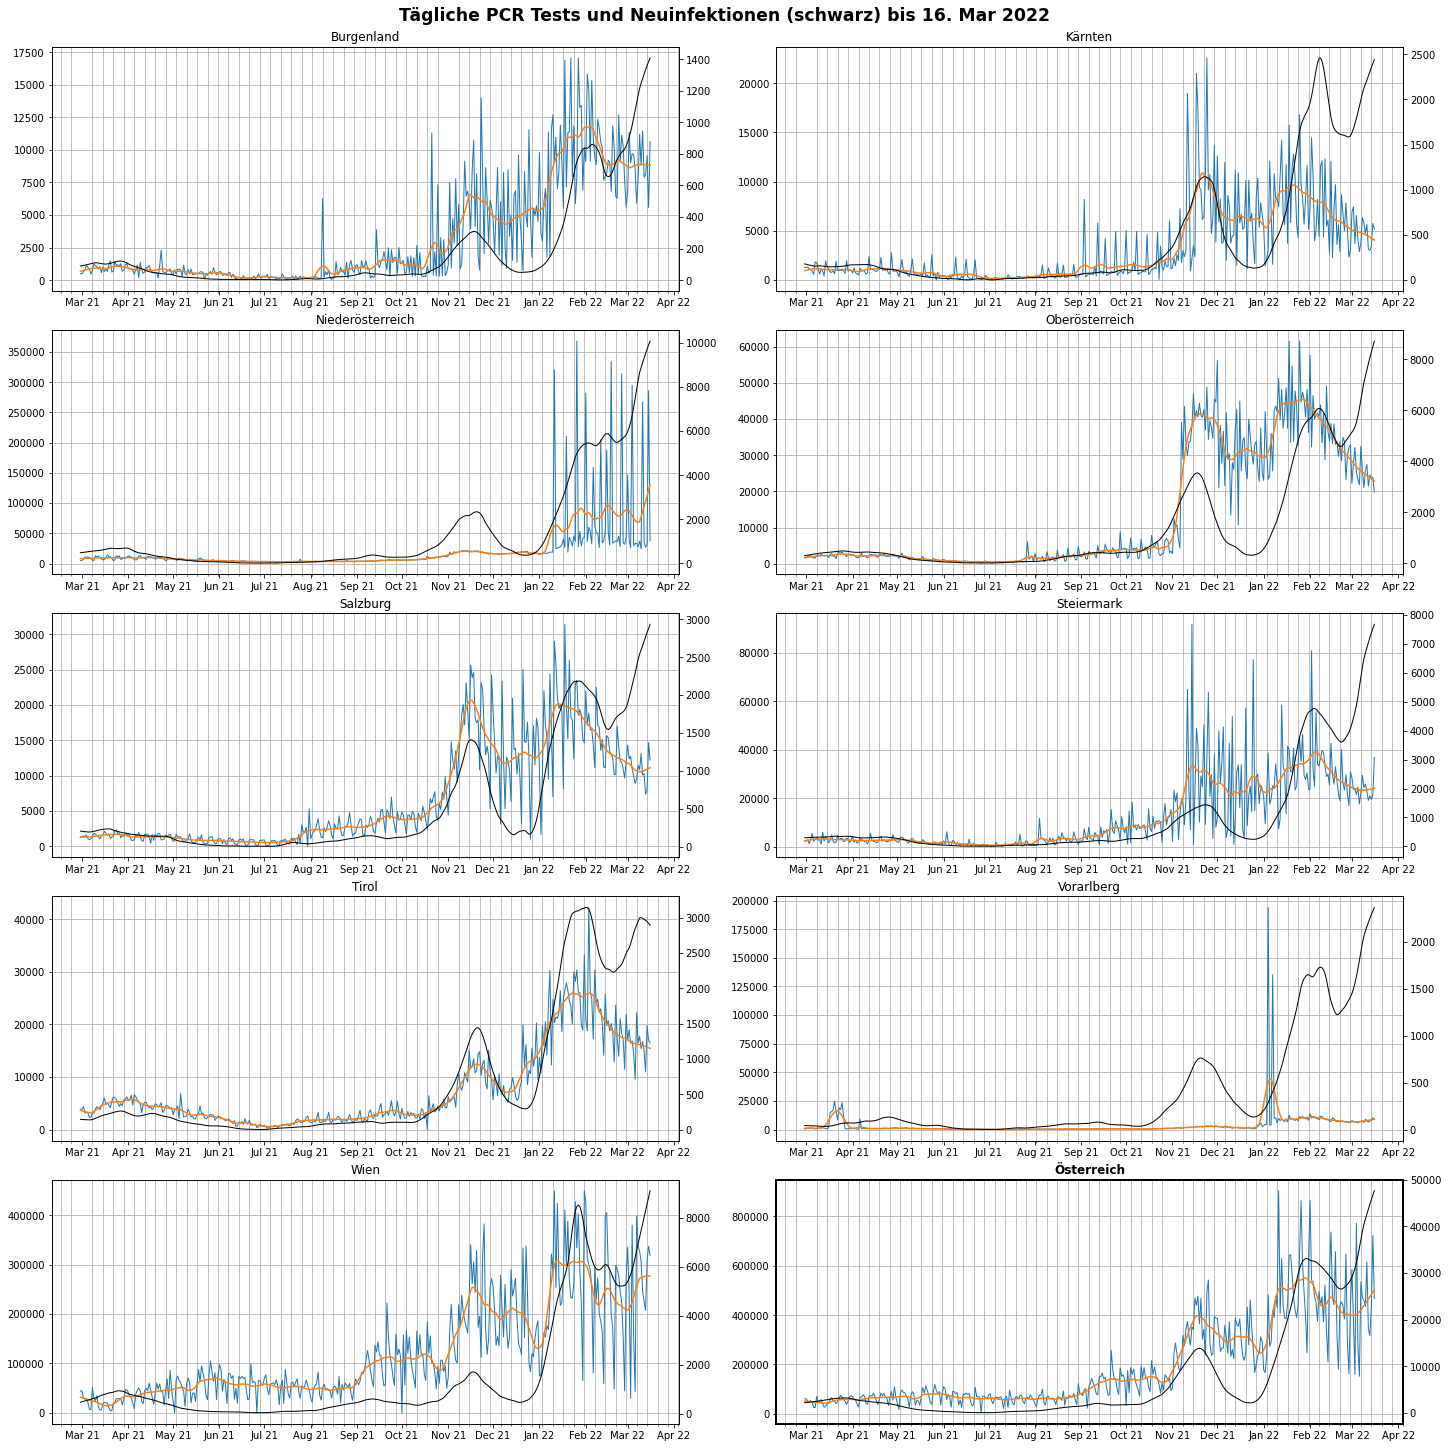

In [26]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)